In [1]:
import pandas as pd
import numpy as np
from datetime import timedelta
from datetime import datetime
import matplotlib.pyplot as plt

hourly_observations = pd.read_csv("./observations.csv", index_col=0, parse_dates=True)
daily_observations = hourly_observations.resample('D').agg(
    {
        "kwh" : "sum",
        "temp": ["min", "max", "mean"]
    }
)
daily_observations["mean_f"] = daily_observations["temp"]["mean"]*1.8 + 32.
daily_observations["hdd"] = np.where(daily_observations["mean_f"]  <=65., 65. - daily_observations["mean_f"], 0.)


weekly_observations = hourly_observations.resample("W").agg(
        {
        "kwh" : "sum",
        "temp": ["min", "max", "mean"]
    }
)
monthly_observations = hourly_observations.resample('ME').agg(
    {
        "kwh" : "sum",
        "temp": ["min", "max", "mean"]
    }
)

# Weekly HDD
hdd = [None]
for i in range(1, len(weekly_observations.index.to_list())) :
    week_start = weekly_observations.index[i-1]
    week_end = weekly_observations.index[i]
    daily_data = daily_observations[(daily_observations.index > week_start) & (daily_observations.index <= week_end)]
    hdd.append(
            np.sum(np.where(daily_data["mean_f"]  <=65., 65. - daily_data["mean_f"], 0.))
    )
weekly_observations["hdd"] = hdd
weekly_observations["hdd"] = weekly_observations["hdd"].replace(0.0, None)

# Monthly HDD
hdd = []
for date in monthly_observations.index:
    month = date.month
    daily_timestamps = [datetime(date.year, date.month, 1) + timedelta(days=i) for i in range(date.day)]
    data = daily_observations[daily_observations.index.isin(daily_timestamps)]
    hdd.append(
            np.sum(np.where(data["mean_f"]  <=65., 65. - data["mean_f"], 0.))
    )
monthly_observations["hdd"] = hdd

years = range(
    np.min([date.year for date in monthly_observations.index]),
    np.max([date.year for date in monthly_observations.index]) + 1
)


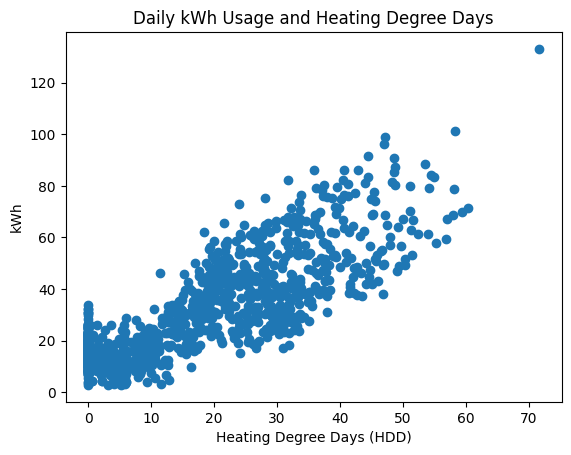

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.690
Model:                            OLS   Adj. R-squared:                  0.690
Method:                 Least Squares   F-statistic:                     2354.
Date:                Mon, 02 Dec 2024   Prob (F-statistic):          3.87e-271
Time:                        15:19:02   Log-Likelihood:                -4049.2
No. Observations:                1059   AIC:                             8102.
Df Residuals:                    1057   BIC:                             8112.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.0798      0.022     48.515      0.0

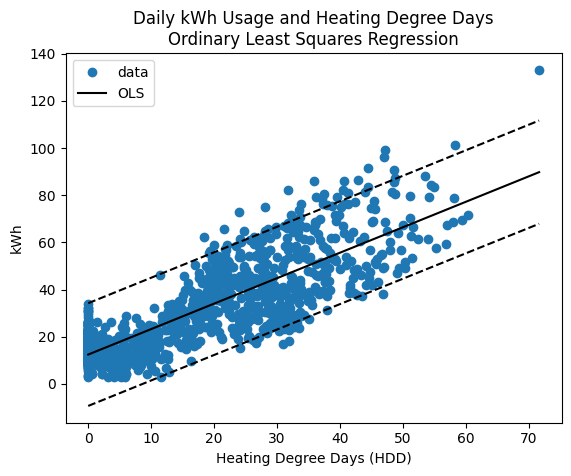

In [2]:
plt.scatter(daily_observations["hdd"], daily_observations["kwh"]["sum"])
plt.xlabel("Heating Degree Days (HDD)")
plt.ylabel("kWh")
plt.title("Daily kWh Usage and Heating Degree Days")
plt.show()

daily_observations["hdd_norm"] = (daily_observations["hdd"]-daily_observations["hdd"].mean())/daily_observations["hdd"].std()
daily_observations["kwh_norm"] = (daily_observations["kwh"]["sum"] - daily_observations["kwh"]["sum"].mean())/daily_observations["kwh"]["sum"].std()

# Ordinary Least Squares
import statsmodels.api as sm

daily_observations_clean: pd.DataFrame = daily_observations.dropna(axis=0)
daily_observations_clean = daily_observations_clean.sort_values(by="hdd", ascending=True)
hdd = daily_observations_clean["hdd"].to_numpy(dtype=float)
kwh = daily_observations_clean["kwh"]["sum"].to_numpy(dtype=float)

A = np.vstack([hdd, np.ones(len(hdd))]).T
model = sm.OLS(kwh, A)
results = model.fit()
print(results.summary())

pred_ols = results.get_prediction()
iv_l = pred_ols.summary_frame()["obs_ci_lower"]
iv_u = pred_ols.summary_frame()["obs_ci_upper"]

plt.plot(hdd, kwh, "o", label="data")
plt.plot(hdd, results.fittedvalues, "k-", label="OLS")
plt.plot(hdd, iv_u, "k--")
plt.plot(hdd, iv_l, "k--")
plt.xlabel("Heating Degree Days (HDD)")
plt.ylabel("kWh")
plt.title("Daily kWh Usage and Heating Degree Days\nOrdinary Least Squares Regression")
plt.legend(loc="best")
plt.show()

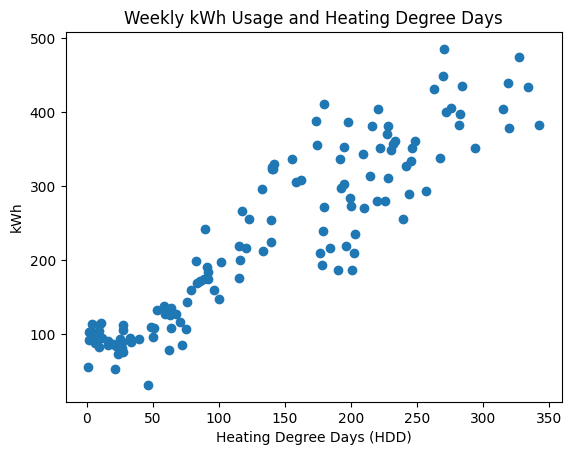

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.838
Model:                            OLS   Adj. R-squared:                  0.837
Method:                 Least Squares   F-statistic:                     661.0
Date:                Mon, 02 Dec 2024   Prob (F-statistic):           2.15e-52
Time:                        15:19:09   Log-Likelihood:                -687.66
No. Observations:                 130   AIC:                             1379.
Df Residuals:                     128   BIC:                             1385.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.1419      0.044     25.710      0.0

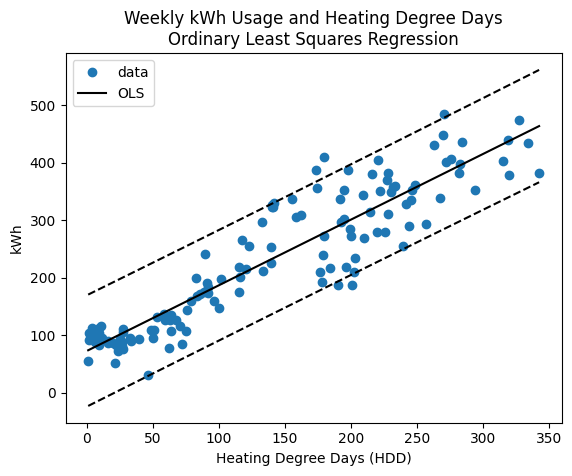

In [3]:
plt.scatter(weekly_observations["hdd"], weekly_observations["kwh"]["sum"])
plt.xlabel("Heating Degree Days (HDD)")
plt.ylabel("kWh")
plt.title("Weekly kWh Usage and Heating Degree Days")
plt.show()

weekly_observations["hdd_norm"] = (weekly_observations["hdd"]-weekly_observations["hdd"].mean())/weekly_observations["hdd"].std()
weekly_observations["kwh_norm"] = (weekly_observations["kwh"]["sum"] - weekly_observations["kwh"]["sum"].mean())/weekly_observations["kwh"]["sum"].std()

# Ordinary Least Squares
import statsmodels.api as sm

weekly_observations_clean: pd.DataFrame = weekly_observations.dropna(axis=0)
weekly_observations_clean = weekly_observations_clean.sort_values(by="hdd", ascending=True)
hdd = weekly_observations_clean["hdd"].to_numpy(dtype=float)
kwh = weekly_observations_clean["kwh"]["sum"].to_numpy(dtype=float)

A = np.vstack([hdd, np.ones(len(hdd))]).T
model = sm.OLS(kwh, A)
results = model.fit()
print(results.summary())

pred_ols = results.get_prediction()
iv_l = pred_ols.summary_frame()["obs_ci_lower"]
iv_u = pred_ols.summary_frame()["obs_ci_upper"]

plt.plot(hdd, kwh, "o", label="data")
plt.plot(hdd, results.fittedvalues, "k-", label="OLS")
plt.plot(hdd, iv_u, "k--")
plt.plot(hdd, iv_l, "k--")
plt.xlabel("Heating Degree Days (HDD)")
plt.ylabel("kWh")
plt.title("Weekly kWh Usage and Heating Degree Days\nOrdinary Least Squares Regression")
plt.legend(loc="best")
plt.show()

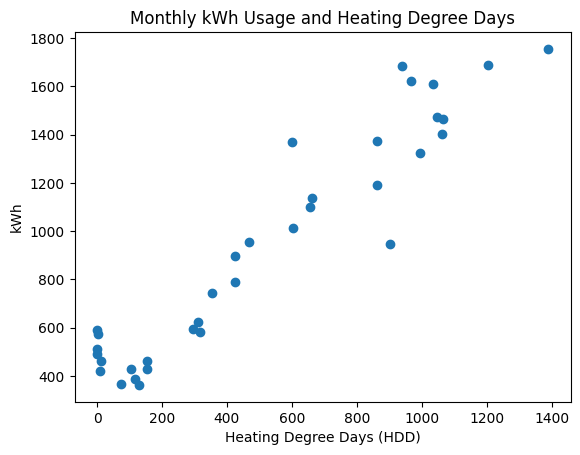

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.902
Model:                            OLS   Adj. R-squared:                  0.899
Method:                 Least Squares   F-statistic:                     303.3
Date:                Mon, 02 Dec 2024   Prob (F-statistic):           3.35e-18
Time:                        15:19:21   Log-Likelihood:                -223.55
No. Observations:                  35   AIC:                             451.1
Df Residuals:                      33   BIC:                             454.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.0411      0.060     17.415      0.0

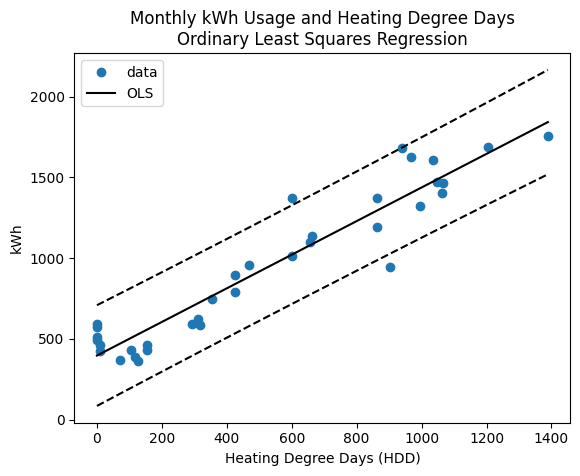

In [4]:
plt.scatter(monthly_observations["hdd"], monthly_observations["kwh"]["sum"])
plt.xlabel("Heating Degree Days (HDD)")
plt.ylabel("kWh")
plt.title("Monthly kWh Usage and Heating Degree Days")
plt.show()

monthly_observations["hdd_norm"] = (monthly_observations["hdd"]-monthly_observations["hdd"].mean())/monthly_observations["hdd"].std()
monthly_observations["kwh_norm"] = (monthly_observations["kwh"]["sum"] - monthly_observations["kwh"]["sum"].mean())/monthly_observations["kwh"]["sum"].std()

# Ordinary Least Squares
import statsmodels.api as sm

monthly_observations_clean: pd.DataFrame = monthly_observations.dropna(axis=0)
monthly_observations_clean = monthly_observations_clean.sort_values(by="hdd", ascending=True)
hdd = monthly_observations_clean["hdd"].to_numpy(dtype=float)
kwh = monthly_observations_clean["kwh"]["sum"].to_numpy(dtype=float)

A = np.vstack([hdd, np.ones(len(hdd))]).T
model = sm.OLS(kwh, A)
results = model.fit()
print(results.summary())

pred_ols = results.get_prediction()
iv_l = pred_ols.summary_frame()["obs_ci_lower"]
iv_u = pred_ols.summary_frame()["obs_ci_upper"]

plt.plot(hdd, kwh, "o", label="data")
plt.plot(hdd, results.fittedvalues, "k-", label="OLS")
plt.plot(hdd, iv_u, "k--")
plt.plot(hdd, iv_l, "k--")
plt.xlabel("Heating Degree Days (HDD)")
plt.ylabel("kWh")
plt.title("Monthly kWh Usage and Heating Degree Days\nOrdinary Least Squares Regression")
plt.legend(loc="best")
plt.show()

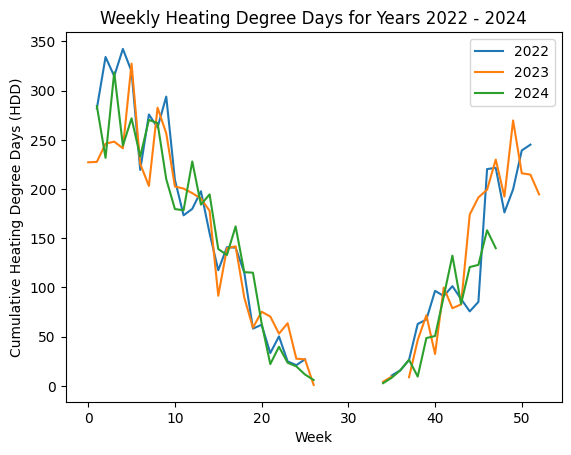

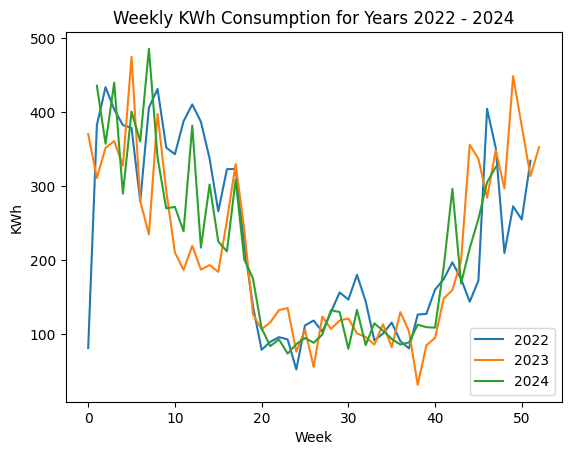

In [8]:
# Weekly data
annualized_data = []
for year in years:
    annualized_data.append(
        weekly_observations[weekly_observations.index.year == year]
    )
    
for i, data in enumerate(annualized_data):
    days = [int((timestamp - datetime(timestamp.year-1, 12, 31)).days /7.) for timestamp in data.index]
    plt.plot(days, data["hdd"], label=years[i])
    plt.xlabel("Week")
    plt.ylabel("Cumulative Heating Degree Days (HDD)")
    plt.title(f"Weekly Heating Degree Days for Years {years[0]} - {years[-1]}")
    plt.legend()    
plt.show()

for i, data in enumerate(annualized_data):
    days = [int((timestamp - datetime(timestamp.year-1, 12, 31)).days /7.) for timestamp in data.index]
    plt.plot(days, data["kwh"], label=years[i])
    plt.xlabel("Week")
    plt.ylabel("KWh")
    plt.title(f"Weekly KWh Consumption for Years {years[0]} - {years[-1]}")
    plt.legend()
plt.show()

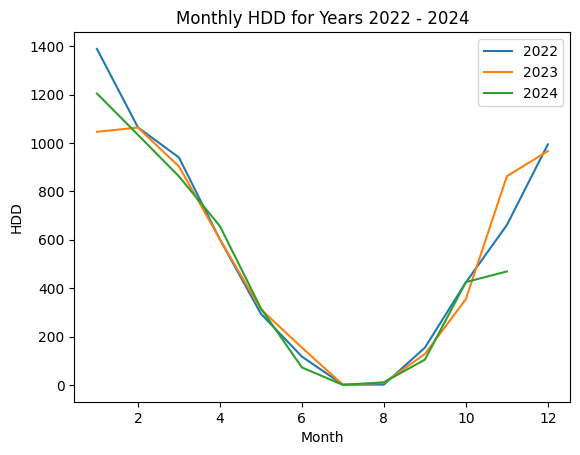

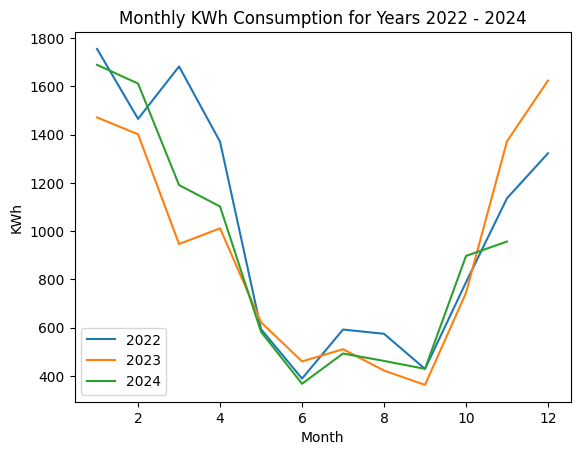

In [7]:
annualized_data = []
annualized_data = []
for year in years:
    annualized_data.append(
        monthly_observations[monthly_observations.index.year == year]
    )

# Plot HDD
for i, data in enumerate(annualized_data):
    plt.plot(range(1,len(data.index) + 1), data["hdd"], label=years[i])
    plt.xlabel("Month")
    plt.ylabel("HDD")
    plt.title(f"Monthly HDD for Years {years[0]} - {years[-1]}")
    plt.legend()
plt.show()

# Plot KWh
for i, data in enumerate(annualized_data):
    plt.plot(range(1,len(data.index) + 1), data["kwh"], label=years[i])
    plt.xlabel("Month")
    plt.ylabel("KWh")
    plt.title(f"Monthly KWh Consumption for Years {years[0]} - {years[-1]}")
    plt.legend()
plt.show()